------------------------
[0.         0.09803922 0.2        0.29803922 0.4        1.        ]


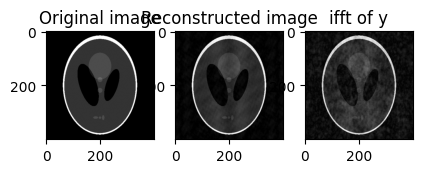

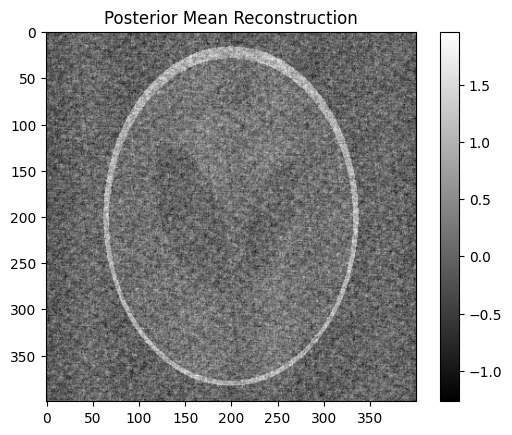

'\nplt.figure()\nplt.imshow(np.log(1 + np.abs(masked_kspace_shepp_shifted)), cmap=\'gray\') # np.log to compress the dynamic range\nplt.colorbar()\nplt.title("Magnitude of Complex Image")\n\nplt.figure()\nplt.imshow(np.angle(masked_kspace_shepp_shifted), cmap=\'twilight\', vmin=-np.pi, vmax=np.pi)\nplt.colorbar()\nplt.title("Phase of Complex Image")\n\nplt.figure()\nplt.imshow(masked_reconstructed)\n\nplt.show()\n'

In [1]:
import sys
import os

# Add the parent directory of MAP to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


import torch 
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from MAP.masks import SimpleMask, BernoulliMask, CenteredBernoulliMask, VariableDensityMask
from MAP.map_tv_minimize import MAPEstimator


# load iamge
shepp_logan = ski.data.shepp_logan_phantom()

# create mask (in the F domain of course)
column_mask = SimpleMask(2).mask_columns(shepp_logan)
row_mask = SimpleMask(3).mask_rows(shepp_logan)
bernoulli_mask = BernoulliMask(0.88, seed=30).generate(shepp_logan.shape)
centered_bernoulli_mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(shepp_logan.shape)
vd_mask = VariableDensityMask('gaussian', 2 , seed=30).generate(shepp_logan.shape)

# the 'actual' measurement
y = vd_mask * np.fft.fft2(shepp_logan)

# x_init options
#x_init = np.fft.ifft2(bernoulli_mask * np.fft.fft2(shepp_logan)).real
x_init = np.zeros_like(np.fft.ifft2(y).real)

# init the MAP
map_estimator = MAPEstimator(vd_mask, 0.95, 0.01, 1e-2, 0.1, 100)

img_reconstruct = map_estimator.subgradient_descent(y)

samples = map_estimator.langevin_sampling(y, 150, 20, 3)
posterior_mean = np.mean(samples, axis=0) # Compute a point estimate (e.g., posterior mean)
posterior_std = np.std(samples, axis=0) # Estimate uncertainty (e.g., pixel-wise variance)

'''
kspace_shepp = np.fft.fft2(shepp_logan)
kspace_shepp_shifted = np.fft.fftshift(kspace_shepp) # shift to center the zero frequency for better visualization

reconstructed = np.real(np.fft.ifft2(kspace_shepp))
reconstructed_mag = np.real(np.fft.ifft2(np.abs(kspace_shepp) * np.exp(1j * 0)))
reconstructed_phase = np.real(np.fft.ifft2(np.exp(1j * np.angle(kspace_shepp))))

#masked_kspace_shepp = column_mask(kspace_shepp)
#masked_kspace_shepp_shifted = np.fft.fftshift(masked_kspace_shepp) # shift to center the zero frequency for better visualization

#masked_reconstructed = np.real(np.fft.ifft2(masked_kspace_shepp))
masked_reconstructed_mag = np.real(np.fft.ifft2(np.abs(kspace_shepp) * np.exp(1j * 0)))
masked_reconstructed_phase = np.real(np.fft.ifft2(np.exp(1j * np.angle(kspace_shepp))))
'''

#print(shepp_logan)
print('------------------------')
print(np.unique(shepp_logan))
#grad_x, grad_y = map_estimator.finite_diff_gradient(shepp_logan)

#print("grad_y - min:", np.min(grad_y), "max:", np.max(grad_y))

#print("max value in x before fft2:", np.max(np.abs(shepp_logan)))

plt.subplot(1, 4, 1)
plt.title("Original image")
plt.imshow(shepp_logan, cmap='gray')
plt.subplot(1, 4, 2)
plt.title("Reconstructed image")
plt.imshow(np.abs(img_reconstruct), cmap='gray')
plt.subplot(1, 4, 3)
plt.title("ifft of y")
plt.imshow(np.abs(np.fft.ifft2(y)), cmap='gray')
#plt.subplot(1, 4, 4)
#plt.title("x_init")
#plt.imshow(np.random.rand(400,400), cmap='gray')
plt.show()

#plt.imshow(img_reconstruct - np.abs(np.fft.ifft2(y)))
#plt.imshow(img_reconstruct - x_init)
#plt.title("Difference image")
#plt.colorbar()


#langevin
plt.imshow(posterior_mean, cmap='gray')
plt.title('Posterior Mean Reconstruction')
plt.colorbar()
plt.show()

#plt.imshow(posterior_std, cmap='hot')
#plt.title('Uncertainty Map')
#plt.colorbar()
#plt.show()

'''
plt.figure()
plt.imshow(np.log(1 + np.abs(masked_kspace_shepp_shifted)), cmap='gray') # np.log to compress the dynamic range
plt.colorbar()
plt.title("Magnitude of Complex Image")

plt.figure()
plt.imshow(np.angle(masked_kspace_shepp_shifted), cmap='twilight', vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.title("Phase of Complex Image")

plt.figure()
plt.imshow(masked_reconstructed)

plt.show()
'''
